# Notebook for results analysis of GAN training. 

In [2]:
#Import of necessary packages and memory allocation.

%matplotlib inline
import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(3)
set_session(tf.Session(config=config))

import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util
import sys
import seaborn as sns
import math
#s = np.random.seed(1)

##### Creation of the channels titles : 

In [3]:
#Plot parameters.

sns.set() #Seaborn theme 

from matplotlib import rc
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
#lab_loc = 2
#lab_font_size = 14
#rc('text', usetex=True)
matplotlib.rc('font', **font)
plt.style.use('seaborn')

## Parameters. 

Setting up parameters for figure generations 

In [4]:
#########
multi_train = True  #If the training was in multiple run : True
plot_var = True     #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

N_gen = 10800      #Number of generation used for statistic analysis /!\ Memory usage important /!\
N_train = 10800
#indxs = np.random.randint(0,1000,N_gen)
#ind = indxs[0]
#########
lons = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')

print(lons)
lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']


if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save
elif N_fields==22:
    runnumber_0 = 'RESNET_V8_gual_Gbn'
    runnumber = runnumber_0 #Most recent save







[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 303.75   306.5

In [5]:
#Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.
if N_fields==82:
    f=h5.File('../data/raw/T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
elif N_fields==22:
    _X_train = np.load('../data/raw/x_train_22c_scaled.npy')
    scaling = np.load('../data/raw/scaling_21c.npy')



print(scaling.shape)

(81, 2)


In [6]:
if N_fields==82:
    var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
    lvls = [100, 200,300,400,500,600,700,800,900,1000]
elif N_fields==22:
    var = ['ta', 'ua', 'va', 'wa', 'pl','lat']
    lvls = [200,500,700,850,1000]


chan_titles = []
for i in var:
    for j in lvls:
        chan_titles.append(i+'_z'+str(j))
chan_titles.append('surface pressure')
#chan_titles.append('latitude')

print(chan_titles)

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surface pressure']


# Loading generator

        - Loading the generator, and generating N_gen samples that will be scaled using the scaling matrix loaded before


In [8]:
sys.path.append('../src/modeling')

sys.path.append('../src/preprocessing')

sys.path.append('../src/preparation')
from SpectralNormalizationKeras import *
from custom_classes import *
from data_preproc import *

try:
    gen = load_model(f'../model/save/{runnumber}/{runnumber}_generator.h5',custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})
except:
    gen = load_model(f'../model/{runnumber}_generator.h5',
          custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})


print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')
print('Database loading...')

if N_fields==82:
    f=h5.File('../data/raw/T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
elif N_fields==22:
    X_train = np.load('../data/raw/x_train_22c_scaled.npy')
    scaling = np.load('../data/raw/scaling_21c.npy')
    
print('Database loaded.')
print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

noise_ = np.load('./fig_82c/noise_.npy')
im = gen.predict(noise_)
im_sc = np.multiply(im[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
X_train, lon = cartopy.util.add_cyclic_point(X_train, coord=lons, axis=2)
fk_imgs, lon = cartopy.util.add_cyclic_point(fk_imgs, coord=lons, axis=2)
im, lon = cartopy.util.add_cyclic_point(im, coord=lons, axis=2)
im_sc, lon = cartopy.util.add_cyclic_point(im_sc, coord=lons, axis=2)



Generating samples...
Samples generated.
scaling...
scaled.
Database loading...
Database loaded.
Scaling...
Scaled


In [9]:
ind = 4115
indx, indf = ind, 0
print(ind)
#fk_imgs=im_sc

noise_ = np.load('./fig_82c/noise_.npy')
im = gen.predict(noise_)
im_sc = np.multiply(im[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
X_train, lon = cartopy.util.add_cyclic_point(X_train, coord=lons, axis=2)
fk_imgs, lon = cartopy.util.add_cyclic_point(fk_imgs, coord=lons, axis=2)
im, lon = cartopy.util.add_cyclic_point(im, coord=lons, axis=2)
im_sc, lon = cartopy.util.add_cyclic_point(im_sc, coord=lons, axis=2)


4115


In [26]:
def zonalPlot(im, N_lvls = N_lvls, title = None):
    im1 = np.mean(im[:,:,0*N_lvls:0*N_lvls+N_lvls], axis = (1))
    
    fig, ax = plt.subplots(2,1, figsize=(10,10))
    fig.subplots_adjust(top=0.95, wspace = 0.35, hspace = 0.3)
    plt.suptitle(title, fontweight = fontweight)
    ax = plt.subplot(211)
    plt.contourf(lat[::],lvls,np.transpose(im1[:,::]), cmap = 'rocket')
    plt.colorbar()
    plt.title('Temperature zonal', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 20, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 20, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 15)
    plt.xticks( fontsize = 15)
    ax.set_ylim(1000,200)
    
    im2 = np.mean(im[:,:,1*N_lvls:1*N_lvls+N_lvls], axis = (1))
    ax = plt.subplot(212)
    plt.contourf(lat[::],lvls,np.transpose(im2[:,::]), cmap = 'mako')
    plt.colorbar()
    plt.title('Zonal wind', fontsize = 20, fontweight = fontweight)
    
    plt.ylabel('pressure level', fontsize = 20, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 20, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 15)
    plt.xticks( fontsize = 15)
    ax.set_ylim(1000,200)
    plt.savefig(f'./fig_82c/{title}.pdf')
    return

def zonalPlot4(im1, im2, N_lvls = N_lvls, title = None):
    
    
    imz1 = np.mean(im1[:,:,0*N_lvls:0*N_lvls+N_lvls], axis = (1))
    imz2 = np.mean(im2[:,:,0*N_lvls:0*N_lvls+N_lvls], axis = (1))
    
    fig, ax = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(top=0.85, left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.55)
    plt.suptitle(title, fontweight = fontweight)
    ax = plt.subplot(221)
    im = ax.contourf(lat[::],lvls,np.transpose(imz1[:,::]), cmap = 'rocket')
    plt.colorbar(im)
    plt.title('(a) \n Temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    
    ax = plt.subplot(222)
    im = ax.contourf(lat[::],lvls,np.transpose(imz2[:,::]),im.levels, cmap = 'rocket')
    plt.colorbar(im)
    plt.title('(b) \n Temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    
    imz1_ = np.mean(im1[:,:,1*N_lvls:1*N_lvls+N_lvls], axis = (1))
    imz2_ = np.mean(im2[:,:,1*N_lvls:1*N_lvls+N_lvls], axis = (1))
    
    ax = plt.subplot(223)
    im = ax.contourf(lat[::],lvls,np.transpose(imz1_[:,::]), cmap = 'mako')
    plt.colorbar(im)
    plt.title('(c) \n Zonal wind ', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    
    ax = plt.subplot(224)
    im = ax.contourf(lat[::],lvls,np.transpose(imz2_[:,::]),im.levels, cmap = 'mako')
    plt.colorbar(im)
    plt.title('(d) \n Zonal wind', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,100)
    plt.savefig(f'./fig_82c/{title.replace(" ","_")}.pdf', bbox_inches='tight')
    return

#zonalPlot4(X_train[indx,:,:,:], fk_imgs[indf,:,:,:], N_lvls = N_lvls, title=f'Temperature and eastward wind zonals')


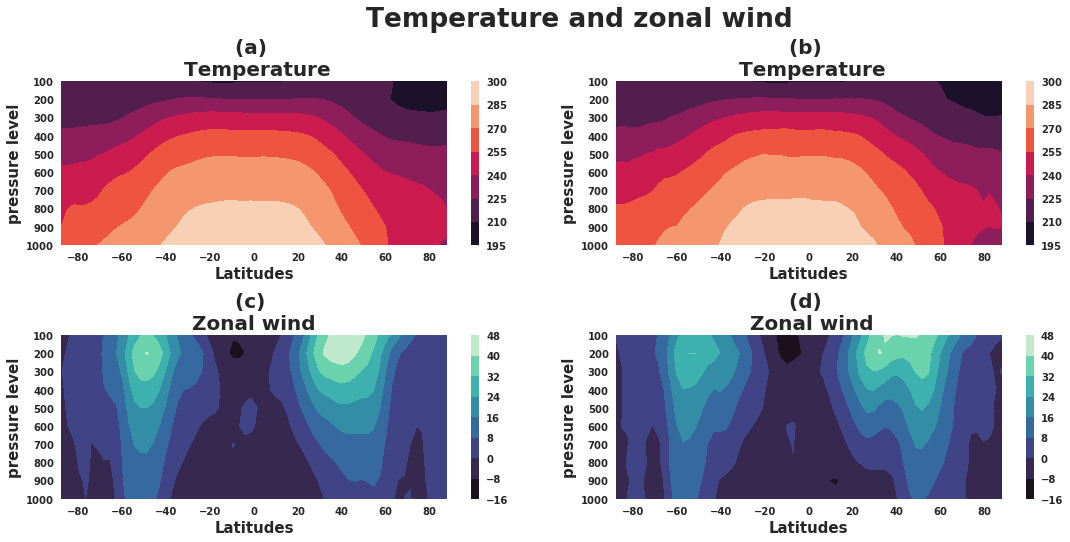

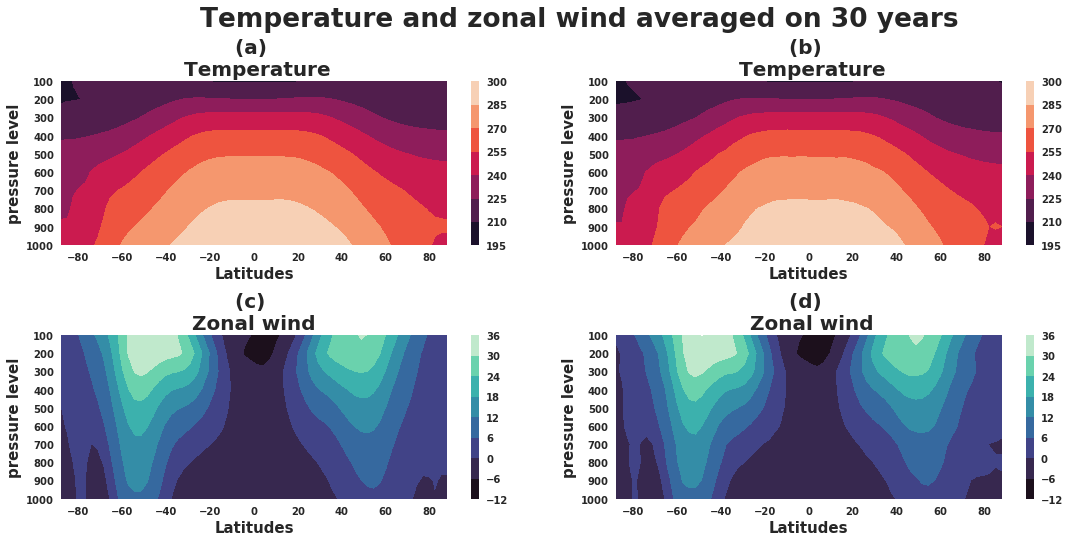

In [28]:
#for i in range(10):
zonalPlot4(X_train[indx-39,:,:,:], im_sc[0,:,:,:], N_lvls = N_lvls, title=f'Temperature and zonal wind')
zonalPlot4(np.mean(X_train, axis=0), np.mean(fk_imgs, axis=0), N_lvls = N_lvls, title=f'Temperature and zonal wind averaged on 30 years')



-2.9850451946258545 0.9046783447265625


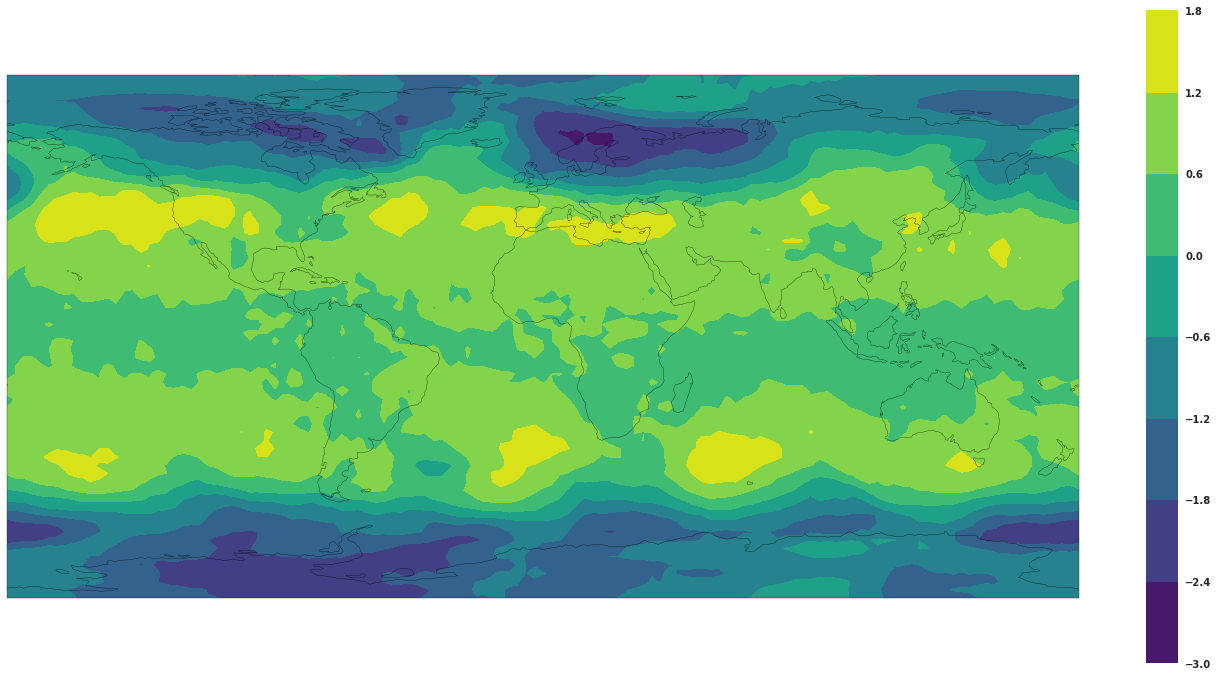

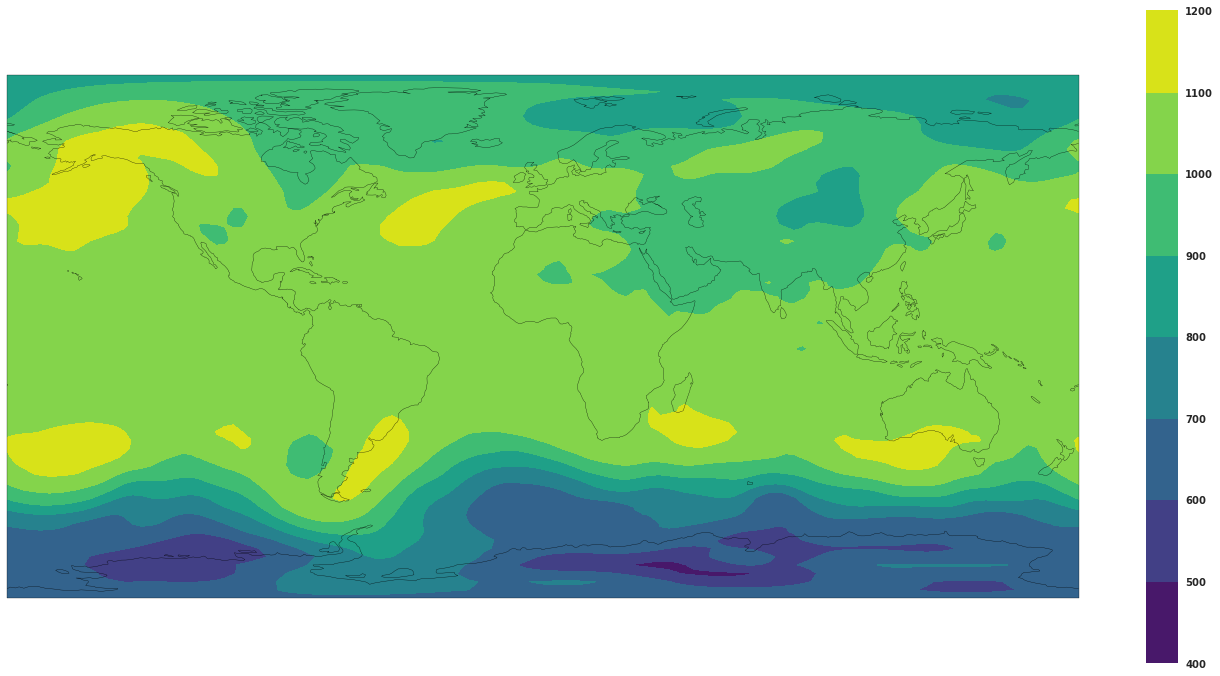

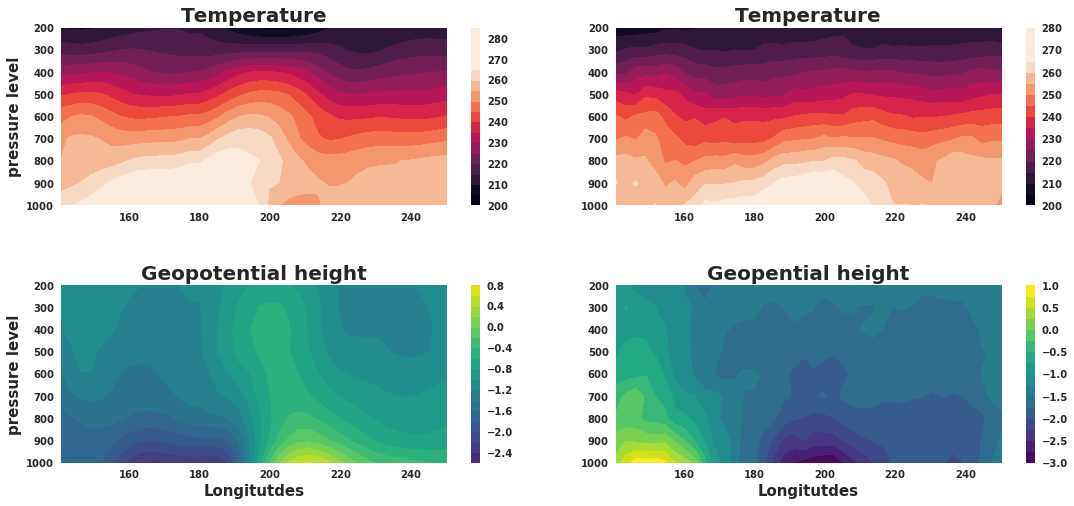

In [29]:
def geowindPlot(im1, im2, scaling, N_lvls = N_lvls, lat_ind=10, lon_ind=[[0,128],[0,128]], ind=0, title = None):
    imz1 = np.roll(im1, 64, axis=1)[lat_ind[0],:,0*N_lvls:0*N_lvls+N_lvls]
    imz2 = np.roll(im2,64,axis=1)[lat_ind[1],:,0*N_lvls:0*N_lvls+N_lvls]
    tmin = np.amin([np.amin(im1[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls]), 
                   np.amin(im2[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls])])
    tmax = np.amax([np.amax(im1[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls]),
                    np.amax(im2[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls])])

    fig, ax = plt.subplots(2,2, figsize=(16,8))
    fig.subplots_adjust(left = 0.05, right = 0.95, wspace = 0.15, hspace = 0.45)
    plt.suptitle(title, fontweight = fontweight)
    ax = plt.subplot(221)
    im = ax.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(imz1[lon_ind[0][0]:lon_ind[0][1],:]),
                     levels=15, cmap='rocket', vmin = tmin, vmax = tmax)
    plt.colorbar(im)
    plt.title('Temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    #plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    
    ax = plt.subplot(222)
    im = ax.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(imz2[lon_ind[1][0]:lon_ind[1][1],:]),
                     levels=15, cmap = 'rocket', vmin = tmin, vmax = tmax)
    plt.colorbar(im)
    plt.title('Temperature', fontsize = 20, fontweight = fontweight)
    #plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    #plt.xlabel('Latitudes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    
    imz1_ = (np.roll(im1, 64, axis=1)[lat_ind[0],:,7*N_lvls:7*N_lvls+N_lvls]-scaling[7*N_lvls:7*N_lvls+N_lvls,0])/scaling[7*N_lvls:7*N_lvls+N_lvls,1]
    imz2_ = (np.roll(im2, 64, axis=1)[lat_ind[1],:,7*N_lvls:7*N_lvls+N_lvls]-scaling[7*N_lvls:7*N_lvls+N_lvls,0])/scaling[7*N_lvls:7*N_lvls+N_lvls,1]
    
    vmin = np.amin([np.amin(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                    np.amin(imz2_[lon_ind[1][0]:lon_ind[1][1],:])])
    vmax = np.amax([np.amax(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                    np.amax(imz2_[lon_ind[1][0]:lon_ind[1][1],:])])
    print(vmin,vmax)
    ax = plt.subplot(223)
    im = ax.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                     levels=15, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Geopotential height', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Longitutdes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    
    ax = plt.subplot(224)
    im = ax.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(imz2_[lon_ind[1][0]:lon_ind[1][1],:]),
                     levels=15, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.title('Geopential height', fontsize = 20, fontweight = fontweight)
    #plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Longitutdes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    ax.set_ylim(1000,200)
    plt.savefig(f'./fig_82c/geopot_temp.pdf', bbox_inches='tight')
    return
#print(im.shape)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(24,12),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax.coastlines()
plt.contourf(lon,lat,im[0,:,:,78], cmap='viridis', transform=ccrs.PlateCarree(central_longitude = 360.))
#plt.scatter(0,0)
plt.colorbar()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(24,12),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax.coastlines()
plt.contourf(lon,lat,X_train[ind+180,:,:,78], cmap='viridis', transform=ccrs.PlateCarree(central_longitude = 360.))
#plt.scatter(0,0)
plt.colorbar()

geowindPlot(X_train[ind-360,:,:,:], im_sc[0,:,:,:], scaling, lat_ind=[9,9], lon_ind=[[50,90],[50,90]])

In [30]:
print(lon)

[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 303.75   306.5

In [31]:
a=[3]
a*3
import math

math.floor(8.14)

8

512.9857098181237 1203.459221139885
204.6527604439284 261.49890144181336
-3.2232048511505127 2.102825880050659
[ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]


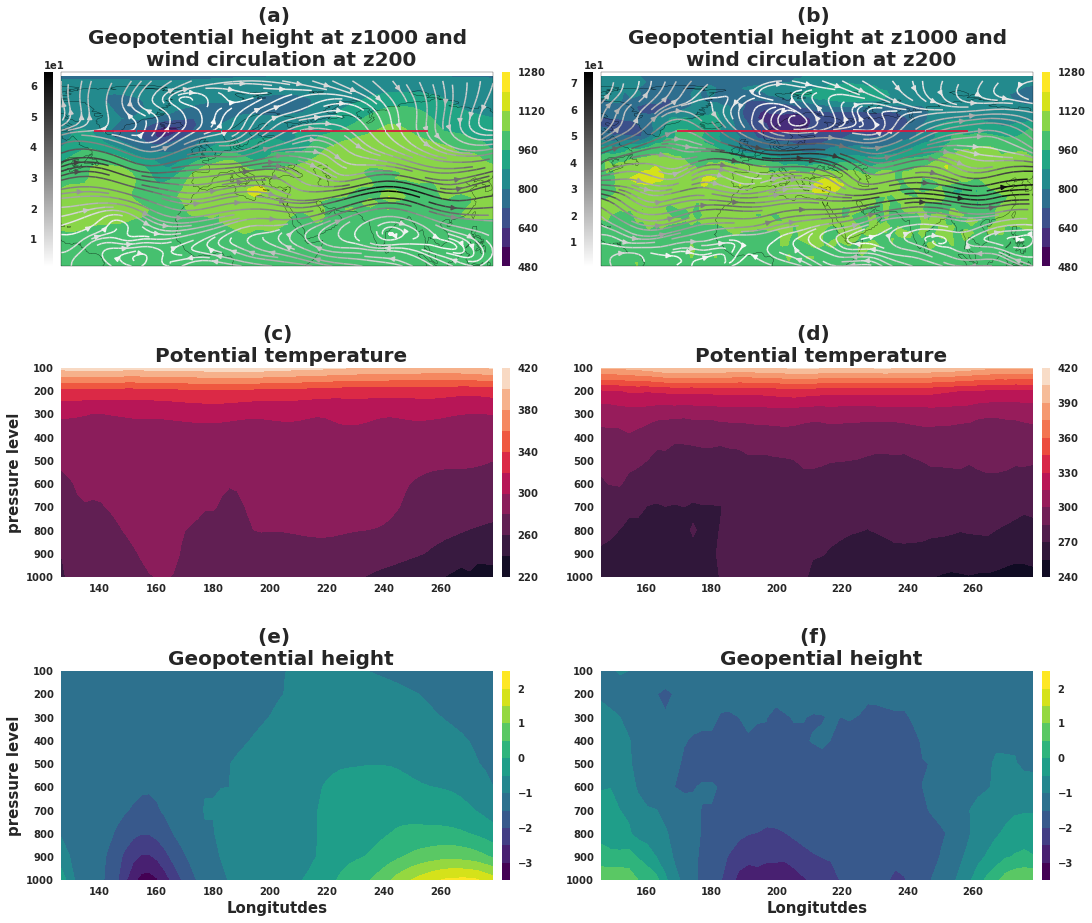

In [80]:

def geowindPlot(im1, im2, scaling, N_lvls = N_lvls, lat_ind=10, lon_ind=[[0,128],[0,128]], ind=0, title = None, cmap=None):
    
    lvl1 = 10
    lvl2 = 10
    lvl3 = 12
    imz1 = np.roll(im1, 64, axis=1)[lat_ind[0],:,0*N_lvls:0*N_lvls+N_lvls]
    imz2 = np.roll(im2, 64, axis=1)[lat_ind[1],:,0*N_lvls:0*N_lvls+N_lvls]
    
    tmin = np.amin([np.amin(im1[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls]), 
                   np.amin(im2[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls])])
    tmax = np.amax([np.amax(im1[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls]),
                    np.amax(im2[lat_ind[1],lon_ind[0][0]:lon_ind[0][1],0*N_lvls:0*N_lvls+N_lvls])])
    
    vmin = np.amin([np.amin(im1[:,:,78]), np.amin(im2[:,:,78])])
    vmax = np.amax([np.amax(im1[:,:,78]), np.amax(im2[:,:,78])])
    print(vmin, vmax)
    print(tmin, tmax)
    fig, ax = plt.subplots(3,2, figsize=(15,15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
    fig.subplots_adjust(left = 0.05, right = 0.95, wspace = 0.25, hspace = 0.45)
    #plt.suptitle(title, fontweight = fontweight)
    ax[0,0].set_extent([-70, 130, 0, 90], crs=ccrs.PlateCarree())
    ax[0,0].coastlines()
    im = ax[0,0].contourf(lon,lat, im1[:,:,78], cmap='viridis', vmin=math.floor(vmin), vmax=math.floor(vmax+1),
                          levels=lvl1, transform=ccrs.PlateCarree(central_longitude = 360.))

    magnitude = (im1[:,:,11] ** 2 + im1[:,:,11+N_lvls] ** 2) ** 0.5
    sp = ax[0,0].streamplot(lon,lat, im1[:,:,11], im1[:,:,11+N_lvls], cmap = cmap,
                   transform=ccrs.PlateCarree(central_longitude=360.), linewidth=1.5, density=1.5, color=magnitude)
    ims = sp.lines

    ax[0,0].scatter(lon[lon_ind[0][0]:lon_ind[0][1]], [ lat[lat_ind[0]] ]*(-lon_ind[0][0]+lon_ind[0][1]), marker='_',color='crimson',
                    s=35., transform=ccrs.PlateCarree(central_longitude = 180.), zorder=10)
    ax[0,0].set_title('(a) \n Geopotential height at z1000 and \n wind circulation at z200', fontsize = 20, fontweight = fontweight)
    posn = ax[0,0].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(im, cax = cax)

    ax[0,1].set_extent([-70, 130, 0, 90], crs=ccrs.PlateCarree())
    ax[0,1].coastlines()
    im = ax[0,1].contourf(lon,lat,im2[:,:,78], cmap='viridis', vmin=math.floor(vmin), vmax=math.floor(vmax+1),
                          levels=im.levels, transform=ccrs.PlateCarree(central_longitude = 360.))
    
    magnitude = (im2[:,:,11] ** 2 + im2[:,:,11+N_lvls] ** 2) ** 0.5
    sp = ax[0,1].streamplot(lon,lat, im2[:,:,11], im2[:,:,11+N_lvls], cmap = cmap,
                   transform=ccrs.PlateCarree(central_longitude=360.), linewidth=1.5, density=1.5, color=magnitude)
    ims2 = sp.lines
    
    ax[0,1].scatter(lon[lon_ind[1][0]:lon_ind[1][1]], [ lat[lat_ind[1]] ]*(-lon_ind[1][0]+lon_ind[1][1]), color='crimson',
                    marker='_', s=35., transform=ccrs.PlateCarree(central_longitude = 180.), zorder=10)
    ax[0,1].set_title('(b) \n Geopotential height at z1000 and \n wind circulation at z200', fontsize = 20, fontweight = fontweight)
    posn = ax[0,1].get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    
    posn = ax[0,1].get_position()
    cax = fig.add_axes([posn.x0 - 0.016, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(ims, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    cax.yaxis.set_ticks_position('left')
    
    posn = ax[0,0].get_position()
    cax = fig.add_axes([posn.x0 - 0.016, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(ims2, cax = cax)
    cax.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
    cax.yaxis.set_ticks_position('left')
    
    geo_temp1 = np.multiply(imz1[lon_ind[0][0]:lon_ind[0][1],:], (1000./np.linspace(100,1000,10))**(2./7))
    geo_temp2 = np.multiply(imz2[lon_ind[1][0]:lon_ind[1][1],:], (1000./np.linspace(100,1000,10))**(2./7))
    
    #geo_temp1 = np.multiply(imz1[lon_ind[0][0]:lon_ind[0][1],:], (1e5/imz1[lon_ind[0][0]:lon_ind[0][1],:])**(2./7))
    #geo_temp2 = np.multiply(imz2[lon_ind[1][0]:lon_ind[1][1],:], (1e5/imz2[lon_ind[0][0]:lon_ind[0][1],:])**(2./7))
    
    axz = plt.subplot(323)
    #ax[1,0].set_extent([-100, 100, 0, 90], crs=ccrs.PlateCarree())
    #im = axz.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(imz1[lon_ind[0][0]:lon_ind[0][1],:]),
    #                 levels=lvl2, cmap='rocket', vmin = tmin, vmax = tmax)
    im = axz.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(geo_temp1),
                     levels=lvl2, cmap='rocket')
    plt.title('(c)\n Potential temperature', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xticks( fontsize = 10)
    axz.set_ylim(1000,100)
    posn = axz.get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    #
    axz = plt.subplot(324)
    #im = axz.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(imz2[lon_ind[1][0]:lon_ind[1][1],:]),
    #                 levels=im.levels, cmap = 'rocket', vmin = tmin, vmax = tmax)
    im = axz.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(geo_temp2),
                     levels=lvl2, cmap = 'rocket')
    plt.title('(d) \n Potential temperature', fontsize = 20, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    axz.set_ylim(1000,100)
    posn = axz.get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    #
    imz1_ = (np.roll(im1, 64, axis=1)[lat_ind[0],:,7*N_lvls:7*N_lvls+N_lvls]-scaling[7*N_lvls:7*N_lvls+N_lvls,0])/scaling[7*N_lvls:7*N_lvls+N_lvls,1]
    imz2_ = (np.roll(im2, 64, axis=1)[lat_ind[1],:,7*N_lvls:7*N_lvls+N_lvls]-scaling[7*N_lvls:7*N_lvls+N_lvls,0])/scaling[7*N_lvls:7*N_lvls+N_lvls,1]
    #
    vmin = np.amin([np.amin(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                    np.amin(imz2_[lon_ind[1][0]:lon_ind[1][1],:])])
    vmax = np.amax([np.amax(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                    np.amax(imz2_[lon_ind[1][0]:lon_ind[1][1],:])])
    print(vmin,vmax)
    axz = plt.subplot(325)
    
    im = axz.contourf(lon[lon_ind[0][0]:lon_ind[0][1]],lvls,np.transpose(imz1_[lon_ind[0][0]:lon_ind[0][1],:]),
                      levels=lvl3, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('(e) \n Geopotential height', fontsize = 20, fontweight = fontweight)
    plt.ylabel('pressure level', fontsize = 15, fontweight = fontweight)
    plt.xlabel('Longitutdes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    axz.set_ylim(1000,100)
    posn = axz.get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    #
    axz = plt.subplot(326)
    im = axz.contourf(lon[lon_ind[1][0]:lon_ind[1][1]],lvls,np.transpose(imz2_[lon_ind[1][0]:lon_ind[1][1],:]),
                      levels=im.levels, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('(f) \n Geopential height', fontsize = 20, fontweight = fontweight)
    plt.xlabel('Longitutdes', fontsize = 15, fontweight = fontweight)
    plt.yticks(lvls[::-1], fontsize = 10)
    plt.xticks( fontsize = 10)
    axz.set_ylim(1000,100)
    posn = axz.get_position()
    cax = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
    cbar = plt.colorbar(im, cax = cax)
    
    plt.savefig(f'./fig_82c/slice_geopot_temp.pdf', bbox_inches='tight')
    return
#print(im.shape)

#fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(24,12),
#                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
#ax.coastlines()
#plt.contourf(lon,lat,im[0,:,:,78], cmap='viridis', transform=ccrs.PlateCarree(central_longitude = 360.))
#plt.scatter(0,0,)
#plt.colorbar()
#
#fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(24,12),
#                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
#ax.coastlines()
#plt.contourf(lon,lat,X_train[ind,:,:,78], cmap='viridis', transform=ccrs.PlateCarree(central_longitude = 360.))
##plt.scatter(0,0)
#plt.colorbar()

geowindPlot(X_train[ind,:,:,:], im_sc[0,:,:,:], scaling, lat_ind=[9,9], lon_ind=[[45,100],[52,100]], cmap='binary')
print(np.linspace(100,1000,10))

In [ ]:
temp_idx = 7
wind_idx = temp_idx+N_lvls-3


tmin = np.amin([ X_train[ind,::,:,temp_idx], 
                fk_imgs[indf,::,:,temp_idx]])
tmax = np.amax([ X_train[ind,::,:,temp_idx], 
                fk_imgs[indf,::,:,temp_idx]])

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(24,12),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(-1)
fig.suptitle(f'Wind thermal balance \n (temperature : z800, wind : z500)', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)
print(ax.shape)

axc = ax[0]
axc.coastlines()
axc.set_title('(a)', fontsize = 18)
cim1 = axc.contourf(lon, lat, X_train[ind,::,:,temp_idx], levels = 20, cmap = 'rocket', vmin=tmin, vmax=tmax,
                   transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'Blues',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.5, density=5., color=magnitude)
im1 = sp.lines

posn = axc.get_position()
cax11 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax11)
cax11.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax11.yaxis.set_ticks_position('left')

posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim1, cax = cax21)
#cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax21.yaxis.set_ticks_position('left')
#cbar = plt.colorbar(im1)

#axc = plt.subplot(212)
axc2 = ax[1]
axc2.set_title('(b)', fontsize = 18)
#axc = [1].axes(projection=ccrs.PlateCarree(central_longitude=0.))
axc2.coastlines()
cim2 = axc2.contourf(lon, lat, fk_imgs[indf,::,:,temp_idx], levels = 20, cmap = 'rocket',
                     transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (fk_imgs[indf,:,:,wind_idx] ** 2 + fk_imgs[indf,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc2.streamplot(lon,lat, fk_imgs[indf,:,:,wind_idx], fk_imgs[indf,:,:,wind_idx+N_lvls], cmap = 'Blues',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.5, density=5., color=magnitude)
im2 = sp.lines

posn = axc2.get_position()
cax12 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax12)
cax12.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax12.yaxis.set_ticks_position('left')

posn = axc2.get_position()
cax22 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
#cax22.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax22.yaxis.set_ticks_position('left')
plt.savefig(f'./fig_82c/wind_thermal_balance_taz800_windz500.pdf', bbox_inches='tight')

(2,)


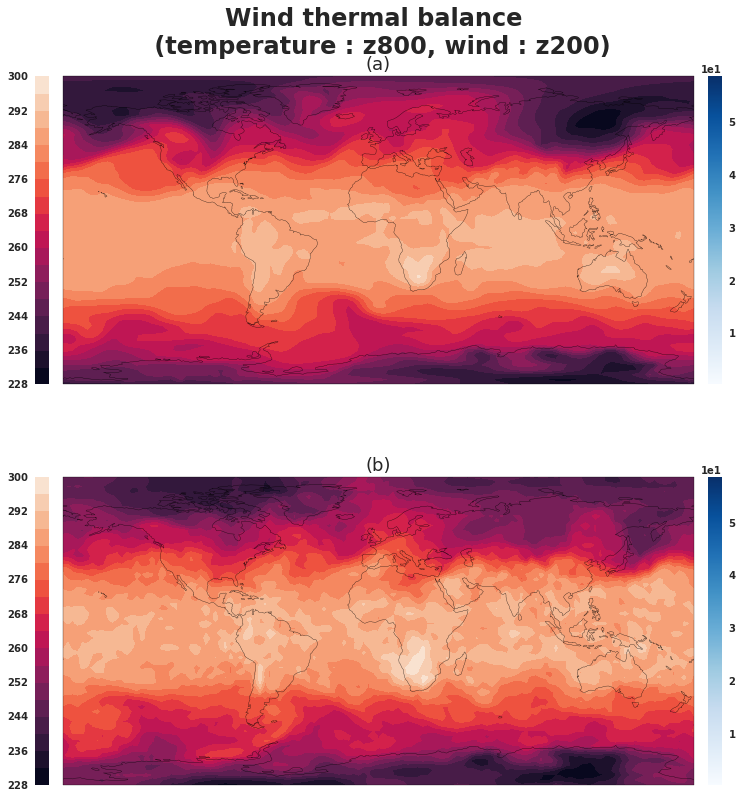

In [34]:

#X_train, lons = cartopy.util.add_cyclic_point(X_train, coord=lon, axis=2)
#fk_imgs, lons = cartopy.util.add_cyclic_point(fk_imgs, coord=lon, axis=2)
cartoproj=360.
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(24,12),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(-1)
fig.suptitle(f'Wind thermal balance \n (temperature : z800, wind : z200)', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.3)
print(ax.shape)

tmin = np.amin([ X_train[ind,::,:,temp_idx], 
                fk_imgs[indf,::,:,temp_idx]])
tmax = np.amax([ X_train[ind,::,:,temp_idx], 
                fk_imgs[indf,::,:,temp_idx]])

axc = ax[0]
axc.coastlines()
axc.set_title('(a)', fontsize = 18)
cim1 = axc.contourf(lon,lat,X_train[ind,::,:,temp_idx], levels = 20, cmap = 'rocket', vmin=tmin, vmax=tmax,
                   transform=ccrs.PlateCarree(central_longitude=cartoproj))


posn = axc.get_position()
cax11 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax11)
cax11.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax11.yaxis.set_ticks_position('left')

posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim1, cax = cax21)
#cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax21.yaxis.set_ticks_position('left')
#cbar = plt.colorbar(im1)

#axc = plt.subplot(212)
axc2 = ax[1]
axc2.set_title('(b)', fontsize = 18)
#axc = [1].axes(projection=ccrs.PlateCarree(central_longitude=0.))
axc2.coastlines()
cim2 = axc2.contourf(lon,lat,fk_imgs[indf,::,:,temp_idx], levels = 20, cmap = 'rocket',  vmin=tmin, vmax=tmax,
                    transform=ccrs.PlateCarree(central_longitude=cartoproj))



posn = axc2.get_position()
cax12 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax12)
cax12.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax12.yaxis.set_ticks_position('left')

posn = axc2.get_position()
cax22 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
#cax22.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax22.yaxis.set_ticks_position('left')

In [ ]:



temp_idx = 77
wind_idx = temp_idx+N_lvls-70

gmin = np.amin([ X_train[ind,:,:,temp_idx], 
                im[0,::,:,temp_idx]])
gmax = np.amax([ X_train[ind,::,:,temp_idx], 
                im[0,::,:,temp_idx]])
gmin = 1400
gmax = 2120
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15,20),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})

ax = ax.reshape(-1)
fig.suptitle(f'Geostrophic wind (z800)', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(left=0.1,right=.9, wspace = 0.35, hspace = 0.2)
print(ax.shape)

axc = ax[0]
axc.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
axc.coastlines(linewidth = 1.)
axc.set_title('(a)', fontsize = 18)
cim1 = axc.contourf(lon, lat, X_train[ind,:,:,temp_idx], levels = 8, cmap = 'viridis',  vmin=gmin, vmax=gmax,
                   transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (X_train[ind,:,:,wind_idx] ** 2 + X_train[ind,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc.streamplot(lon,lat, X_train[ind,:,:,wind_idx], X_train[ind,:,:,wind_idx+N_lvls], cmap = 'Reds',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=.95, density=2.5, color=magnitude)
im1 = sp.lines

posn = axc.get_position()
cax11 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax11)
cax11.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax11.yaxis.set_ticks_position('left')

posn = axc.get_position()
cax21 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim1, cax = cax21)
#cax21.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax21.yaxis.set_ticks_position('left')
#cbar = plt.colorbar(im1)

#axc = plt.subplot(212)
axc2 = ax[1]
axc2.set_extent([-60, 60, 20, 88], crs=ccrs.PlateCarree())
axc2.set_title('(b)', fontsize = 18)
#axc = [1].axes(projection=ccrs.PlateCarree(central_longitude=0.))
axc2.coastlines(linewidth = 1.)
cim2 = axc2.contourf(lon, lat, im[0,:,:,temp_idx]*scaling[temp_idx,1]+scaling[temp_idx,0], vmin=gmin, vmax=gmax,
                     levels = cim1.levels, cmap = 'viridis', transform=ccrs.PlateCarree(central_longitude=360.))

magnitude = (im[0,:,:,wind_idx] ** 2 + im[0,:,:,wind_idx+N_lvls] ** 2) ** 0.5
sp = axc2.streamplot(lon,lat, im[0,:,:,wind_idx], im[0,:,:,wind_idx+N_lvls], cmap = 'Reds',
               transform=ccrs.PlateCarree(central_longitude=360.),linewidth=0.95, density=2.5, color=magnitude)
im2 = sp.lines

posn = axc2.get_position()
cax12 = fig.add_axes([posn.x0 + posn.width + 0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(im1, cax = cax12)
cax12.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
#cax12.yaxis.set_ticks_position('left')

posn = axc2.get_position()
cax22 = fig.add_axes([posn.x0 - 2*0.008, posn.y0, 0.008, posn.height])
cbar = plt.colorbar(cim2, cax = cax22)
#cax22.ticklabel_format( axis='both', style='sci',scilimits=(0,0), useOffset=None, useLocale=None, useMathText=None)
cax22.yaxis.set_ticks_position('left')
plt.savefig(f'./fig_82c/geostrophic_wind_z800.pdf', bbox='tight')